In [1]:
import os
import shutil
import torch
import numpy as np
from torch import nn
from torchvision.transforms import transforms
import yaml
import logging
import sys
import csv
import torch
import torch.nn.functional as F
import torchvision.models as models
from types import SimpleNamespace
import torch.backends.cudnn as cudnn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img
        
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [4]:
class SimCLR(object):

    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        # self.writer = SummaryWriter()
        # logging.basicConfig(filename=os.path.join(self.writer.log_dir, 'training.log'), level=logging.DEBUG)
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

        os.makedirs(self.args.log_dir, exist_ok=True)
        logging.basicConfig(filename=os.path.join(self.args.log_dir, 'training.log'),
                            level=logging.INFO,
                            format='%(asctime)s - %(levelname)s - %(message)s')

        self.csv_log_path = os.path.join(self.args.log_dir, 'metrics.csv')
        with open(self.csv_log_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['step', 'loss', 'acc_top1', 'acc_top5', 'learning_rate'])

        

    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.args.batch_size) for i in range(self.args.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.args.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        # assert similarity_matrix.shape == (
        #     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
        # assert similarity_matrix.shape == labels.shape

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.args.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.args.device)

        logits = logits / self.args.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled=self.args.fp16_precision)

        # save config file
        # save_config_file(self.writer.log_dir, self.args)

        n_iter = 0
        best_top1 = 0.0  
        logging.info(f"Start SimCLR training for {self.args.epochs} epochs.")

        for epoch_counter in range(self.args.epochs):
            for images, _ in tqdm(train_loader):
                images = torch.cat(images, dim=0)

                images = images.to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                if n_iter % self.args.log_every_n_steps == 0:
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    lr = self.scheduler.get_last_lr()[0]

                    print(f"[Epoch {epoch_counter+1}] Step {n_iter}: Loss={loss:.4f}, Top1={top1[0]:.2f}%, Top5={top5[0]:.2f}%, LR={lr:.6f}")


                    # File log
                    with open(self.csv_log_path, mode='a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([n_iter, loss.item(), top1[0].item(), top5[0].item(), lr])

                    if top1[0].item() > best_top1:
                        best_top1 = top1[0].item()
                        best_ckpt_path = os.path.join(self.args.log_dir, 'checkpoint_best.pth')
                        save_checkpoint({
                            'epoch': epoch_counter + 1,
                            'arch': self.args.arch,
                            'state_dict': self.model.state_dict(),
                            'optimizer': self.optimizer.state_dict(),
                            'best_top1': best_top1
                        }, is_best=True, filename=best_ckpt_path)
                        logging.info(f"New best model saved with Top1={best_top1:.2f}% at epoch {epoch_counter+1}, step {n_iter}")

                    

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            logging.debug(f"Epoch: {epoch_counter}\tLoss: {loss}\tTop1 accuracy: {top1[0]}")

        logging.info("Training has finished.")
        # save model checkpoints
        checkpoint_name = os.path.join(self.args.log_dir, f'checkpoint_{self.args.epochs:04d}.pth.tar')
        
        save_checkpoint({
            'epoch': self.args.epochs,
            'arch': self.args.arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, is_best=False, filename=checkpoint_name)

In [5]:
class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""

In [6]:
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]

In [7]:
from torchvision.transforms import transforms
from torchvision import transforms, datasets

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from PIL import Image


class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder

    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            
            # --- INI YANG DIMODIFIKASI ---
            # Menambahkan augmentasi baru dengan probabilitas 20%
            transforms.RandomApply([transforms.RandomSolarize(threshold=128)], p=0.2),
            
            GaussianBlur(kernel_size=int(0.1 * size)),
            transforms.ToTensor()
        ])
        return data_transforms

    def get_dataset(self, name, n_views):
        valid_datasets = {
                        'cifar10': lambda: datasets.CIFAR10(self.root_folder, train=True,
                                                          transform=ContrastiveLearningViewGenerator(
                                                              self.get_simclr_pipeline_transform(32),
                                                              n_views),
                                                          download=True),
                        'stl10': lambda: datasets.STL10(self.root_folder, split='unlabeled',
                                                      transform=ContrastiveLearningViewGenerator(
                                                          self.get_simclr_pipeline_transform(96),
                                                          n_views),
                                                      download=True),
                        'tinyimagenet' : lambda: ImageFolder(
                            root=os.path.join(self.root_folder, 'tiny-imagenet-200', 'train'),
                            transform=ContrastiveLearningViewGenerator(
                                self.get_simclr_pipeline_transform(64),  
                                n_views))
                        }

        try:
            dataset_fn = valid_datasets[name]
        except KeyError:
            raise InvalidDatasetSelection()
        else:
            return dataset_fn()

In [8]:
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(weights=None, num_classes=out_dim),
                            "resnet34": models.resnet34(weights=None, num_classes=out_dim),
                            "resnet50": models.resnet50(weights=None, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            # Pesan error juga diperbarui untuk menyertakan 'resnet34'
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18, resnet34, or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

In [9]:
model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))
print(model_names)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model', 'get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception_v3', 'list_models', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_

In [10]:
if __name__ == '__main__':
    args = SimpleNamespace()
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.data = '/kaggle/working/data'
    cudnn.deterministic = True
    cudnn.benchmark = True
    args.dataset_name = 'cifar10'
    args.n_views = 2
    args.batch_size = 256
    args.out_dim = 128
    args.lr = 0.0003
    args.weight_decay = 1e-4
    args.arch = 'resnet34'
    args.workers = 2
    args.gpu_index = 0
    args.log_dir = '/kaggle/working/logs/simclr_resnet34_solarize'
    args.fp16_precision = True
    args.epochs = 20
    args.temperature = 0.07
    args.seed = 1
    args.log_every_n_steps = 100
    dataset = ContrastiveLearningDataset(args.data)

model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.weight_decay)

train_dataset = dataset.get_dataset(args.dataset_name, args.n_views)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, drop_last=True)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                       last_epoch=-1)

if args.device.type == 'cuda':
        with torch.cuda.device(args.gpu_index):
            simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
            simclr.train(train_loader)
else: 
        print("CUDA not found. Training on CPU...")
        simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
        simclr.train(train_loader)

100%|██████████| 170M/170M [00:03<00:00, 49.9MB/s] 
/tmp/ipykernel_36/4097389895.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=self.args.fp16_precision)
  0%|          | 0/195 [00:00<?, ?it/s]/tmp/ipykernel_36/4097389895.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16_precision):
  1%|          | 1/195 [00:06<21:01,  6.50s/it]

[Epoch 1] Step 0: Loss=6.7129, Top1=0.39%, Top5=1.76%, LR=0.000300


 51%|█████▏    | 100/195 [00:46<00:41,  2.30it/s]

[Epoch 1] Step 100: Loss=5.8575, Top1=1.76%, Top5=6.25%, LR=0.000300


  3%|▎         | 5/195 [00:02<01:28,  2.14it/s]

[Epoch 2] Step 200: Loss=5.7207, Top1=3.91%, Top5=9.96%, LR=0.000300


 54%|█████▍    | 105/195 [00:44<00:37,  2.41it/s]

[Epoch 2] Step 300: Loss=5.6228, Top1=4.30%, Top5=12.11%, LR=0.000300


  5%|▍         | 9/195 [00:04<01:19,  2.35it/s]

[Epoch 3] Step 400: Loss=5.5073, Top1=5.86%, Top5=14.45%, LR=0.000300


 56%|█████▋    | 110/195 [00:45<00:35,  2.39it/s]

[Epoch 3] Step 500: Loss=5.3858, Top1=5.66%, Top5=16.99%, LR=0.000300


  8%|▊         | 15/195 [00:06<01:14,  2.42it/s]

[Epoch 4] Step 600: Loss=5.4104, Top1=5.86%, Top5=15.23%, LR=0.000300


 59%|█████▉    | 115/195 [00:47<00:32,  2.47it/s]

[Epoch 4] Step 700: Loss=5.4359, Top1=6.64%, Top5=15.82%, LR=0.000300


 10%|▉         | 19/195 [00:08<01:12,  2.43it/s]

[Epoch 5] Step 800: Loss=5.3008, Top1=10.16%, Top5=22.27%, LR=0.000300


 62%|██████▏   | 120/195 [00:49<00:32,  2.27it/s]

[Epoch 5] Step 900: Loss=5.0098, Top1=13.67%, Top5=26.37%, LR=0.000300


 13%|█▎        | 25/195 [00:10<01:10,  2.42it/s]

[Epoch 6] Step 1000: Loss=5.1315, Top1=11.13%, Top5=25.00%, LR=0.000300


 64%|██████▍   | 125/195 [00:51<00:28,  2.47it/s]

[Epoch 6] Step 1100: Loss=4.9134, Top1=12.11%, Top5=29.88%, LR=0.000300


 16%|█▌        | 31/195 [00:13<01:06,  2.48it/s]

[Epoch 7] Step 1200: Loss=5.0122, Top1=12.89%, Top5=26.76%, LR=0.000300


 67%|██████▋   | 130/195 [00:52<00:25,  2.57it/s]

[Epoch 7] Step 1300: Loss=4.7721, Top1=14.65%, Top5=29.10%, LR=0.000300


 18%|█▊        | 35/195 [00:14<01:08,  2.34it/s]

[Epoch 8] Step 1400: Loss=4.7937, Top1=14.84%, Top5=30.86%, LR=0.000300


 70%|██████▉   | 136/195 [00:55<00:21,  2.79it/s]

[Epoch 8] Step 1500: Loss=4.6849, Top1=14.84%, Top5=31.25%, LR=0.000300


 20%|██        | 39/195 [00:16<01:03,  2.45it/s]

[Epoch 9] Step 1600: Loss=4.7606, Top1=16.60%, Top5=32.03%, LR=0.000300


 72%|███████▏  | 140/195 [00:57<00:22,  2.46it/s]

[Epoch 9] Step 1700: Loss=4.7895, Top1=18.16%, Top5=33.59%, LR=0.000300


 23%|██▎       | 45/195 [00:19<01:02,  2.41it/s]

[Epoch 10] Step 1800: Loss=4.6271, Top1=17.19%, Top5=33.79%, LR=0.000300


 74%|███████▍  | 145/195 [01:00<00:20,  2.43it/s]

[Epoch 10] Step 1900: Loss=4.5926, Top1=17.97%, Top5=32.23%, LR=0.000300


 25%|██▌       | 49/195 [00:20<01:00,  2.40it/s]

[Epoch 11] Step 2000: Loss=4.6237, Top1=18.55%, Top5=33.59%, LR=0.000300


 77%|███████▋  | 150/195 [01:02<00:19,  2.30it/s]

[Epoch 11] Step 2100: Loss=4.3638, Top1=22.46%, Top5=38.87%, LR=0.000300


 28%|██▊       | 55/195 [00:23<01:03,  2.22it/s]

[Epoch 12] Step 2200: Loss=4.1697, Top1=25.98%, Top5=41.41%, LR=0.000300


 80%|████████  | 156/195 [01:05<00:17,  2.22it/s]

[Epoch 12] Step 2300: Loss=4.3979, Top1=22.07%, Top5=38.09%, LR=0.000300


 31%|███▏      | 61/195 [00:25<00:55,  2.40it/s]

[Epoch 13] Step 2400: Loss=4.1816, Top1=25.20%, Top5=43.36%, LR=0.000300


 83%|████████▎ | 161/195 [01:06<00:14,  2.42it/s]

[Epoch 13] Step 2500: Loss=4.3131, Top1=22.85%, Top5=39.06%, LR=0.000300


 33%|███▎      | 65/195 [00:27<00:56,  2.31it/s]

[Epoch 14] Step 2600: Loss=4.0245, Top1=28.32%, Top5=44.92%, LR=0.000300


 85%|████████▌ | 166/195 [01:08<00:12,  2.34it/s]

[Epoch 14] Step 2700: Loss=4.1394, Top1=24.41%, Top5=41.80%, LR=0.000300


 36%|███▋      | 71/195 [00:29<00:49,  2.53it/s]

[Epoch 15] Step 2800: Loss=4.0219, Top1=27.93%, Top5=44.73%, LR=0.000300


 88%|████████▊ | 171/195 [01:09<00:10,  2.31it/s]

[Epoch 15] Step 2900: Loss=4.1729, Top1=24.41%, Top5=38.87%, LR=0.000300


 38%|███▊      | 75/195 [00:30<00:47,  2.52it/s]

[Epoch 16] Step 3000: Loss=4.2030, Top1=25.39%, Top5=41.60%, LR=0.000300


 90%|████████▉ | 175/195 [01:11<00:08,  2.39it/s]

[Epoch 16] Step 3100: Loss=3.8382, Top1=29.49%, Top5=44.34%, LR=0.000300


 41%|████      | 80/195 [00:33<00:48,  2.38it/s]

[Epoch 17] Step 3200: Loss=4.0639, Top1=24.80%, Top5=43.16%, LR=0.000299


 92%|█████████▏| 180/195 [01:14<00:06,  2.41it/s]

[Epoch 17] Step 3300: Loss=4.3933, Top1=24.41%, Top5=37.89%, LR=0.000299


 44%|████▎     | 85/195 [00:35<00:45,  2.43it/s]

[Epoch 18] Step 3400: Loss=4.2239, Top1=24.80%, Top5=36.91%, LR=0.000299


 95%|█████████▌| 186/195 [01:17<00:03,  2.69it/s]

[Epoch 18] Step 3500: Loss=4.2697, Top1=22.46%, Top5=38.48%, LR=0.000299


 46%|████▌     | 90/195 [00:37<00:38,  2.72it/s]

[Epoch 19] Step 3600: Loss=3.8805, Top1=29.69%, Top5=47.07%, LR=0.000299


 97%|█████████▋| 190/195 [01:19<00:02,  2.27it/s]

[Epoch 19] Step 3700: Loss=3.6361, Top1=35.35%, Top5=49.02%, LR=0.000299


 49%|████▊     | 95/195 [00:40<00:42,  2.35it/s]

[Epoch 20] Step 3800: Loss=3.8660, Top1=28.71%, Top5=45.31%, LR=0.000298


100%|██████████| 195/195 [01:22<00:00,  2.38it/s]


In [11]:
with torch.cuda.device(args.gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)

/tmp/ipykernel_36/4097389895.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=self.args.fp16_precision)
  0%|          | 0/195 [00:00<?, ?it/s]/tmp/ipykernel_36/4097389895.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16_precision):


[Epoch 1] Step 0: Loss=3.8477, Top1=28.12%, Top5=47.46%, LR=0.000298


 51%|█████     | 99/195 [00:42<00:39,  2.42it/s]

[Epoch 1] Step 100: Loss=3.7276, Top1=32.23%, Top5=49.61%, LR=0.000298


  3%|▎         | 5/195 [00:02<01:31,  2.07it/s]

[Epoch 2] Step 200: Loss=3.8113, Top1=30.86%, Top5=48.83%, LR=0.000298


 54%|█████▍    | 106/195 [00:44<00:35,  2.49it/s]

[Epoch 2] Step 300: Loss=3.7231, Top1=26.37%, Top5=49.80%, LR=0.000298


  6%|▌         | 12/195 [00:05<01:08,  2.66it/s]

[Epoch 3] Step 400: Loss=3.8706, Top1=30.27%, Top5=47.46%, LR=0.000298


 57%|█████▋    | 111/195 [00:47<00:33,  2.52it/s]

[Epoch 3] Step 500: Loss=3.8165, Top1=30.27%, Top5=47.46%, LR=0.000298


  8%|▊         | 15/195 [00:07<01:19,  2.26it/s]

[Epoch 4] Step 600: Loss=3.6420, Top1=34.18%, Top5=50.39%, LR=0.000298


 59%|█████▉    | 115/195 [00:48<00:32,  2.46it/s]

[Epoch 4] Step 700: Loss=3.5491, Top1=35.55%, Top5=50.00%, LR=0.000298


 11%|█         | 21/195 [00:09<01:11,  2.44it/s]

[Epoch 5] Step 800: Loss=3.8552, Top1=30.86%, Top5=48.63%, LR=0.000298


 62%|██████▏   | 121/195 [00:49<00:29,  2.48it/s]

[Epoch 5] Step 900: Loss=3.6922, Top1=31.05%, Top5=49.41%, LR=0.000298


 13%|█▎        | 26/195 [00:10<01:02,  2.70it/s]

[Epoch 6] Step 1000: Loss=3.7788, Top1=33.79%, Top5=50.78%, LR=0.000298


 64%|██████▍   | 125/195 [00:51<00:27,  2.57it/s]

[Epoch 6] Step 1100: Loss=3.5344, Top1=36.33%, Top5=55.08%, LR=0.000298


 16%|█▌        | 31/195 [00:13<01:07,  2.42it/s]

[Epoch 7] Step 1200: Loss=3.5509, Top1=34.18%, Top5=52.15%, LR=0.000298


 67%|██████▋   | 131/195 [00:54<00:26,  2.41it/s]

[Epoch 7] Step 1300: Loss=3.4597, Top1=34.57%, Top5=54.69%, LR=0.000298


 18%|█▊        | 35/195 [00:14<01:05,  2.44it/s]

[Epoch 8] Step 1400: Loss=3.6159, Top1=36.52%, Top5=51.56%, LR=0.000298


 69%|██████▉   | 135/195 [00:57<00:25,  2.33it/s]

[Epoch 8] Step 1500: Loss=3.5018, Top1=37.50%, Top5=53.71%, LR=0.000298


 21%|██        | 41/195 [00:17<01:04,  2.38it/s]

[Epoch 9] Step 1600: Loss=3.5653, Top1=34.18%, Top5=51.17%, LR=0.000298


 72%|███████▏  | 141/195 [00:59<00:22,  2.40it/s]

[Epoch 9] Step 1700: Loss=3.5402, Top1=34.57%, Top5=50.98%, LR=0.000298


 24%|██▎       | 46/195 [00:19<00:55,  2.66it/s]

[Epoch 10] Step 1800: Loss=3.3075, Top1=37.50%, Top5=54.88%, LR=0.000298


 75%|███████▍  | 146/195 [01:00<00:18,  2.64it/s]

[Epoch 10] Step 1900: Loss=3.3597, Top1=33.01%, Top5=52.34%, LR=0.000298


 26%|██▌       | 51/195 [00:21<00:57,  2.49it/s]

[Epoch 11] Step 2000: Loss=3.6796, Top1=33.59%, Top5=50.00%, LR=0.000298


 77%|███████▋  | 150/195 [01:02<00:19,  2.32it/s]

[Epoch 11] Step 2100: Loss=3.1131, Top1=40.62%, Top5=58.20%, LR=0.000298


 28%|██▊       | 55/195 [00:23<00:57,  2.43it/s]

[Epoch 12] Step 2200: Loss=3.6410, Top1=36.52%, Top5=51.17%, LR=0.000298


 80%|████████  | 156/195 [01:05<00:14,  2.74it/s]

[Epoch 12] Step 2300: Loss=3.5428, Top1=35.74%, Top5=53.32%, LR=0.000298


 31%|███▏      | 61/195 [00:25<00:53,  2.50it/s]

[Epoch 13] Step 2400: Loss=3.1206, Top1=36.91%, Top5=56.25%, LR=0.000297


 83%|████████▎ | 161/195 [01:05<00:13,  2.47it/s]

[Epoch 13] Step 2500: Loss=3.2161, Top1=37.11%, Top5=55.66%, LR=0.000297


 33%|███▎      | 65/195 [00:28<00:54,  2.40it/s]

[Epoch 14] Step 2600: Loss=3.1109, Top1=41.21%, Top5=59.96%, LR=0.000297


 85%|████████▌ | 166/195 [01:11<00:11,  2.54it/s]

[Epoch 14] Step 2700: Loss=3.2108, Top1=41.02%, Top5=58.79%, LR=0.000297


 36%|███▋      | 71/195 [00:30<00:56,  2.18it/s]

[Epoch 15] Step 2800: Loss=3.3723, Top1=36.91%, Top5=55.08%, LR=0.000296


 87%|████████▋ | 170/195 [01:13<00:10,  2.41it/s]

[Epoch 15] Step 2900: Loss=2.9456, Top1=45.90%, Top5=61.33%, LR=0.000296


 38%|███▊      | 75/195 [00:32<00:49,  2.42it/s]

[Epoch 16] Step 3000: Loss=3.3015, Top1=39.84%, Top5=54.88%, LR=0.000296


 90%|████████▉ | 175/195 [01:16<00:08,  2.27it/s]

[Epoch 16] Step 3100: Loss=3.3202, Top1=34.77%, Top5=53.91%, LR=0.000296


 42%|████▏     | 81/195 [00:35<00:48,  2.34it/s]

[Epoch 17] Step 3200: Loss=3.3695, Top1=38.09%, Top5=55.08%, LR=0.000295


 93%|█████████▎| 181/195 [01:17<00:05,  2.35it/s]

[Epoch 17] Step 3300: Loss=3.1055, Top1=39.45%, Top5=57.03%, LR=0.000295


 44%|████▎     | 85/195 [00:36<00:47,  2.33it/s]

[Epoch 18] Step 3400: Loss=3.2308, Top1=42.77%, Top5=58.40%, LR=0.000294


 95%|█████████▍| 185/195 [01:18<00:04,  2.41it/s]

[Epoch 18] Step 3500: Loss=3.0726, Top1=44.34%, Top5=61.33%, LR=0.000294


 47%|████▋     | 91/195 [00:39<00:54,  1.92it/s]

[Epoch 19] Step 3600: Loss=3.2557, Top1=37.70%, Top5=54.30%, LR=0.000294


 97%|█████████▋| 190/195 [01:21<00:02,  2.16it/s]

[Epoch 19] Step 3700: Loss=3.1719, Top1=37.89%, Top5=55.47%, LR=0.000294


 49%|████▊     | 95/195 [00:41<00:45,  2.21it/s]

[Epoch 20] Step 3800: Loss=3.3968, Top1=39.06%, Top5=56.25%, LR=0.000293


100%|██████████| 195/195 [01:23<00:00,  2.32it/s]


--- Menganalisis Hasil Training ---

[INFO] 5 Baris Pertama Data Training:
   step      loss   acc_top1   acc_top5  learning_rate
0     0  3.847743  28.125000  47.460938       0.000298
1   100  3.727643  32.226562  49.609375       0.000298
2   200  3.811269  30.859375  48.828125       0.000298
3   300  3.723143  26.367188  49.804688       0.000298
4   400  3.870550  30.273438  47.460938       0.000298

[INFO] 5 Baris Terakhir Data Training:
    step      loss   acc_top1   acc_top5  learning_rate
34  3400  3.230757  42.773438  58.398438       0.000294
35  3500  3.072597  44.335938  61.328125       0.000294
36  3600  3.255723  37.695312  54.296875       0.000294
37  3700  3.171875  37.890625  55.468750       0.000294
38  3800  3.396769  39.062500  56.250000       0.000293

[INFO] Ringkasan Statistik:
            loss   acc_top1   acc_top5
count  39.000000  39.000000  39.000000
mean    3.459658  35.932492  53.405449
std     0.256633   4.258738   3.817820
min     2.945642  26.367188  47.46

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

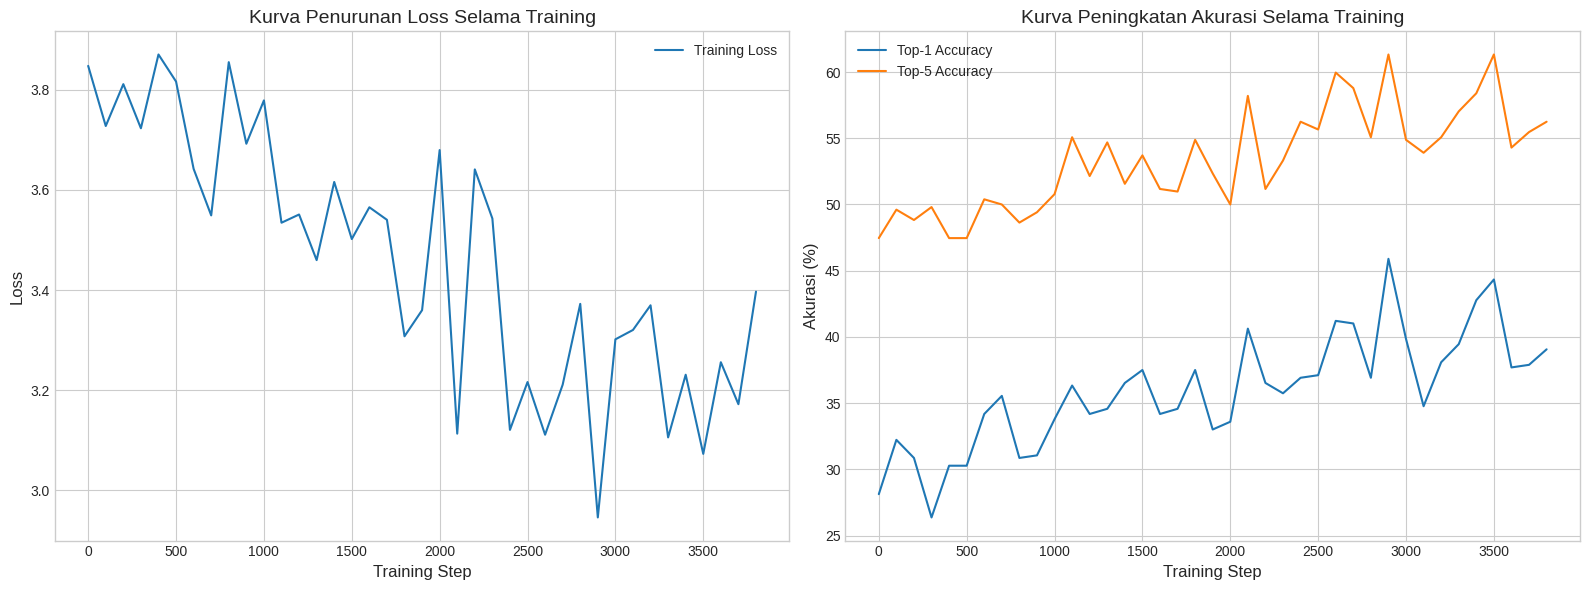

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Tentukan path ke file log CSV Anda
log_file_path = '/kaggle/working/logs/simclr_resnet34_solarize/metrics.csv'

# --- 1. PRINT DATA ---
print("--- Menganalisis Hasil Training ---")

# Cek apakah file hasil training ada
if not os.path.exists(log_file_path):
    print(f"Error: File tidak ditemukan di '{log_file_path}'")
    print("Pastikan sel training sudah selesai berjalan dan path sudah benar.")
else:
    # Muat data menggunakan Pandas
    df = pd.read_csv(log_file_path)

    # Print beberapa baris pertama untuk melihat awal training
    print("\n[INFO] 5 Baris Pertama Data Training:")
    print(df.head())

    # Print beberapa baris terakhir untuk melihat akhir training
    print("\n[INFO] 5 Baris Terakhir Data Training:")
    print(df.tail())

    # Print ringkasan statistik
    print("\n[INFO] Ringkasan Statistik:")
    print(df[['loss', 'acc_top1', 'acc_top5']].describe())


    # --- 2. PLOT GRAFIK ---

    # Atur style plot agar lebih menarik
    plt.style.use('seaborn-v0_8-whitegrid')

    # Buat figure untuk menampung 2 plot
    plt.figure(figsize=(16, 6))

    # Plot 1: Kurva Loss
    plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1
    sns.lineplot(x='step', y='loss', data=df, label='Training Loss')
    plt.title('Kurva Penurunan Loss Selama Training', fontsize=14)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()

    # Plot 2: Kurva Akurasi
    plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2
    sns.lineplot(x='step', y='acc_top1', data=df, label='Top-1 Accuracy')
    sns.lineplot(x='step', y='acc_top5', data=df, label='Top-5 Accuracy')
    plt.title('Kurva Peningkatan Akurasi Selama Training', fontsize=14)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Akurasi (%)', fontsize=12)
    plt.legend()

    # Tampilkan plot
    plt.tight_layout() # Merapikan layout
    plt.show()